In [1]:
import sys
import torch
from torch import nn

sys.path.append("../") # if running from this folder
from src.models import TCN
from src.utils import count_parameters

In [2]:
tcn_params = {
    'groups': 5, # number of causal variables
    'in_channels': 5,  # multiple of groups
    'out_channels': 25,  # multiple of groups
    'hidden_dim': 40,  # multiple of groups
    'kernel_size': 3,
    'n_blocks': 4,
    'n_layers': 2,
    'dropout': 0.2,
}

def print_info(model):
    print({'receptive_field': model.receptive_field, 'n_parameters': count_parameters(model)})

## TCN

In [3]:
model = TCN(**tcn_params)
print_info(model)
print(f'\nArchitecture:\n{model}')

{'receptive_field': 61, 'n_parameters': 7705}

Architecture:
TCN(
  (tcn): DefaultTCN(
    (network): Sequential(
      (0): TemporalBlock(
        (dropout): Dropout(p=0.2, inplace=False)
        (relu): ReLU()
        (convolutions): ModuleList(
          (0): ParametrizedConv1d(
            5, 40, kernel_size=(3,), stride=(1,), groups=5
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _WeightNorm()
              )
            )
          )
          (1): ParametrizedConv1d(
            40, 40, kernel_size=(3,), stride=(1,), groups=5
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _WeightNorm()
              )
            )
          )
        )
      )
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): TemporalBlock(
        (dropout): Dropout(p=0.2, inplace=False)
        (relu): ReLU()
        (convolutions): ModuleList(
          (0-1): 2 x

## Recurrent TCN

In [4]:
model = TCN(**tcn_params, recurrent=True)
print_info(model)

{'receptive_field': 61, 'n_parameters': 3545}


## Weight-Sharing TCN

In [5]:
model = TCN(**tcn_params, weight_sharing=True)
print_info(model)

{'receptive_field': 61, 'n_parameters': 2713}


## Recurrent Weight-Sharing TCN

In [6]:
model = TCN(**tcn_params, recurrent=True, weight_sharing=True)
print_info(model)

{'receptive_field': 61, 'n_parameters': 1881}


## Padding

In [7]:
batch_size, time_steps = 1, 100
data = torch.randn(batch_size, tcn_params['in_channels'], time_steps)
print('data:', data.shape)

# No padding results in time steps - receptive_field + 1
model = TCN(**tcn_params, use_padding=False)
print('no padding:', model(data).shape)

# Zero padding results in same time steps
model = TCN(**tcn_params, use_padding=True)
print('padding:', model(data).shape)

data: torch.Size([1, 5, 100])
no padding: torch.Size([1, 25, 40])
padding: torch.Size([1, 25, 100])


## Positional Embedding

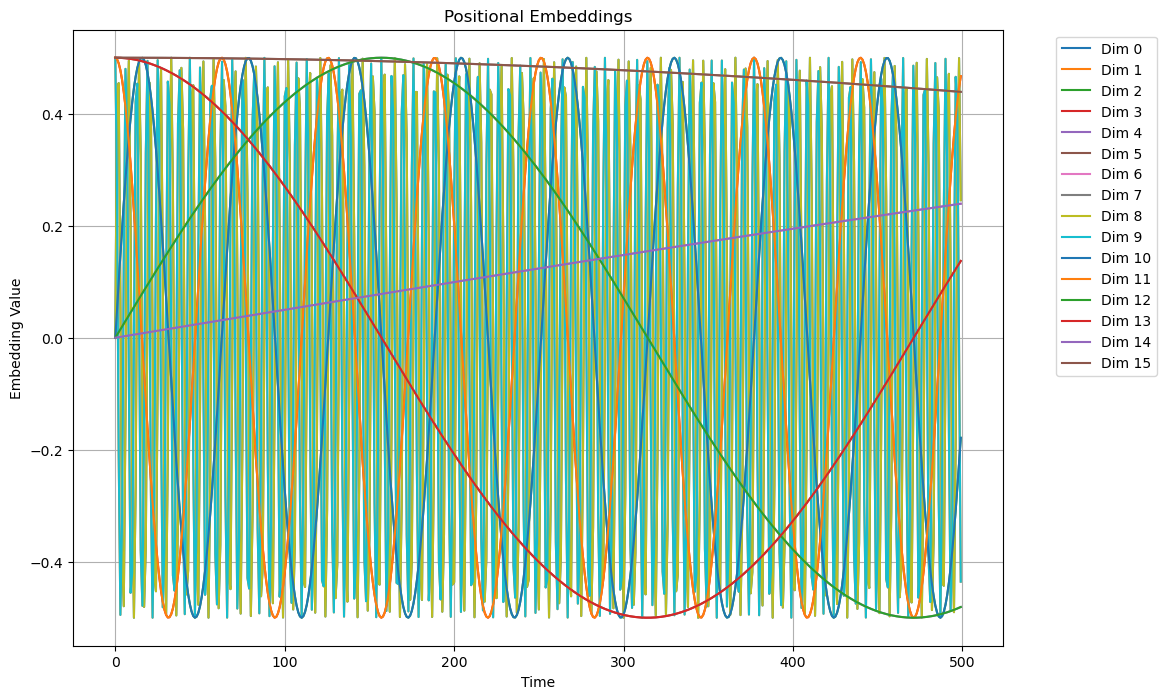

In [10]:
import matplotlib.pyplot as plt
from src.models.TCN import PositionalEmbedding

# Initialize the positional embedding module
hidden_dim = 16  # Example hidden dimension size
max_length = 100  # Visualizing first 100 positions for clarity
model = TCN(**tcn_params, use_positional_embedding=True)
pos_embed_module = model.tcn.network[0].positional_embedding

# Get the positional embedding values
pos_embedding = pos_embed_module.pos_embedding.squeeze(0).detach()  # Remove batch dimension and detach from graph
pos_embedding = pos_embedding[..., :500] # show first 500 only

# Plotting
plt.figure(figsize=(12, 8))
for i in range(hidden_dim):
    plt.plot(pos_embedding[i], label=f'Dim {i}')

plt.title('Positional Embeddings')
plt.xlabel('Time')
plt.ylabel('Embedding Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
